# Exploring the non-stationary nature of air temperature data

## Train a GP

In [1]:
import geopandas as gpd
import torch
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio as rio

city = 'Seattle'
gdf = gpd.read_file(f'../data/shapefiles/{city}/pm_trav.shp')
gdf.columns

Index(['hasFix', 'stlltsU', 'date', 'time', 'altitud', 'course', 'spdKmhr',
       'spdKnts', 'RMCMode', 'RMCStts', 'Humidty', 'Temprtr', 'BAT', 'rh',
       't_c', 't_f', 'case', 'ht_ndx_f', 'ht_ndx_c', 'file', 'dat_cln',
       'dttm_tc', 'dttm_lc', 'tz', 'date_lc', 'strt_tm', 'end_tim', 'trav_id',
       'geometry'],
      dtype='object')

In [2]:
gdf.total_bounds
gdf.crs

<Geographic 2D CRS: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
gdf = gdf.to_crs(epsg=3857) # in meters
bounds = gdf.total_bounds
bounds

array([-13625330.34489869,   5974660.06076669, -13549363.14139409,
         6069359.48645944])

In [4]:
cd ../src

/Users/student/Code/uhi-deep-learning/src


### Visualize city land cover

In [82]:
from utils import custom_colormap

ed


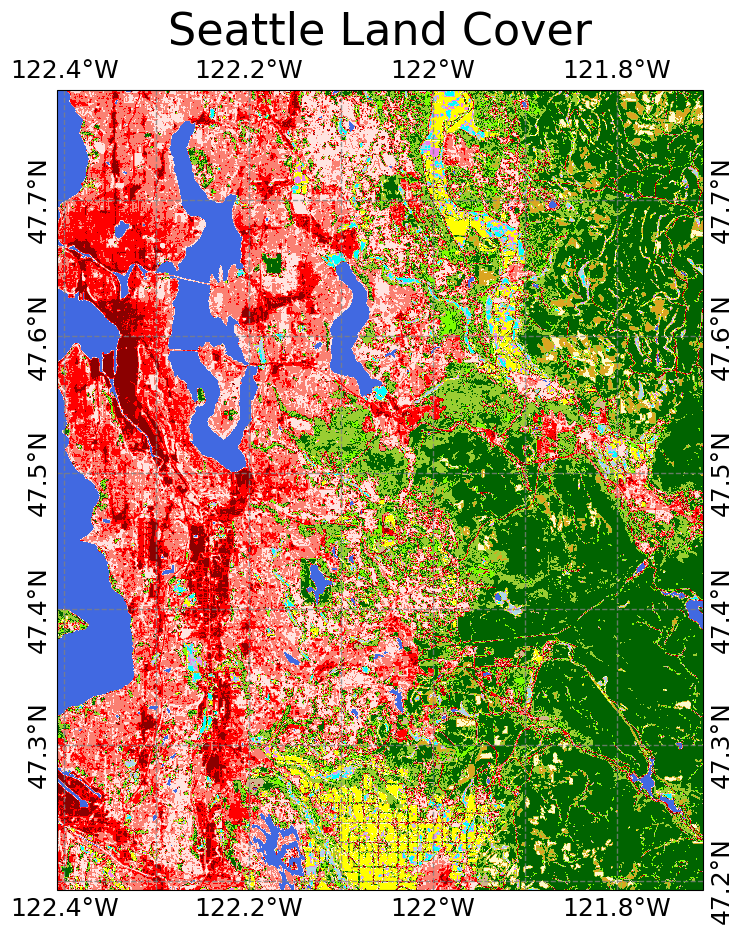

In [49]:
tif_nlcd = f'../data/land/{city}_nlcd.tif'
with rio.open(tif_nlcd) as src:
    nlcd = src.read(1)
    bounds = src.bounds


new_nlcd = nlcd.copy()
for i, j in enumerate(np.unique(nlcd)):
    new_nlcd[nlcd == j] = i

# Generate land cover colormap
fig = plt.figure(figsize=(10, 10))

# Plot the raster data
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.8, linestyle='--', ylabel_style={'size': 18, 'rotation': 'vertical'}, xlabel_style={'size': 18})

img = plt.imshow(new_nlcd, extent=img_extent, cmap=custom_colormap())

# Add scatter points for the coordinates
# ax.scatter(converted_coordinates[1], converted_coordinates[0], color='black', s=400, transform=ccrs.PlateCarree(), label='Sample Points')

# Add legend for points
# ax.legend(loc='upper right', fontsize=12)

fig.suptitle(f'{city} Land Cover', fontsize=32)

# Save or display the plot
# plt.savefig(f'../figures/{city}_nlcd.png', dpi=300, bbox_inches='tight')
plt.show()

### Data preprocessing

In [5]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
coordinates = gdf[['x', 'y']].to_numpy()
print(coordinates)

[[-13616917.74544695   6038604.45649993]
 [-13616921.64162913   6038606.38209413]
 [-13616926.09440877   6038606.93226399]
 ...
 [-13603436.21298195   6042616.12513904]
 [-13603434.72872207   6042603.46536625]
 [-13603434.17212462   6042593.28251899]]


In [6]:
gdf.columns # Check the heading associated with the temperature in Fahrenheit

Index(['hasFix', 'stlltsU', 'date', 'time', 'altitud', 'course', 'spdKmhr',
       'spdKnts', 'RMCMode', 'RMCStts', 'Humidty', 'Temprtr', 'BAT', 'rh',
       't_c', 't_f', 'case', 'ht_ndx_f', 'ht_ndx_c', 'file', 'dat_cln',
       'dttm_tc', 'dttm_lc', 'tz', 'date_lc', 'strt_tm', 'end_tim', 'trav_id',
       'geometry', 'x', 'y'],
      dtype='object')

In [7]:
X, y = coordinates, gdf.t_f.to_numpy()

Train-test split

In [8]:
import numpy as np
train_indices = np.random.choice(len(X), size=10000, replace=False)

# Get the remaining indices for testing
remaining_indices = np.setdiff1d(np.arange(len(X)), train_indices)

# Randomly select 1000 indices for testing from the remaining points
test_indices = np.random.choice(remaining_indices, size=1000, replace=False)

Data normalization

for interpretability reasons, dn't standardize

In [9]:
# Now, we need to standardize the data
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_norm = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_norm = (y - y_mean) / (y_std)

In [10]:
x_train, y_train, x_test, y_test = x_norm[train_indices], y_norm[train_indices], x_norm[test_indices], y_norm[test_indices]

### Visualize train and test data on the map

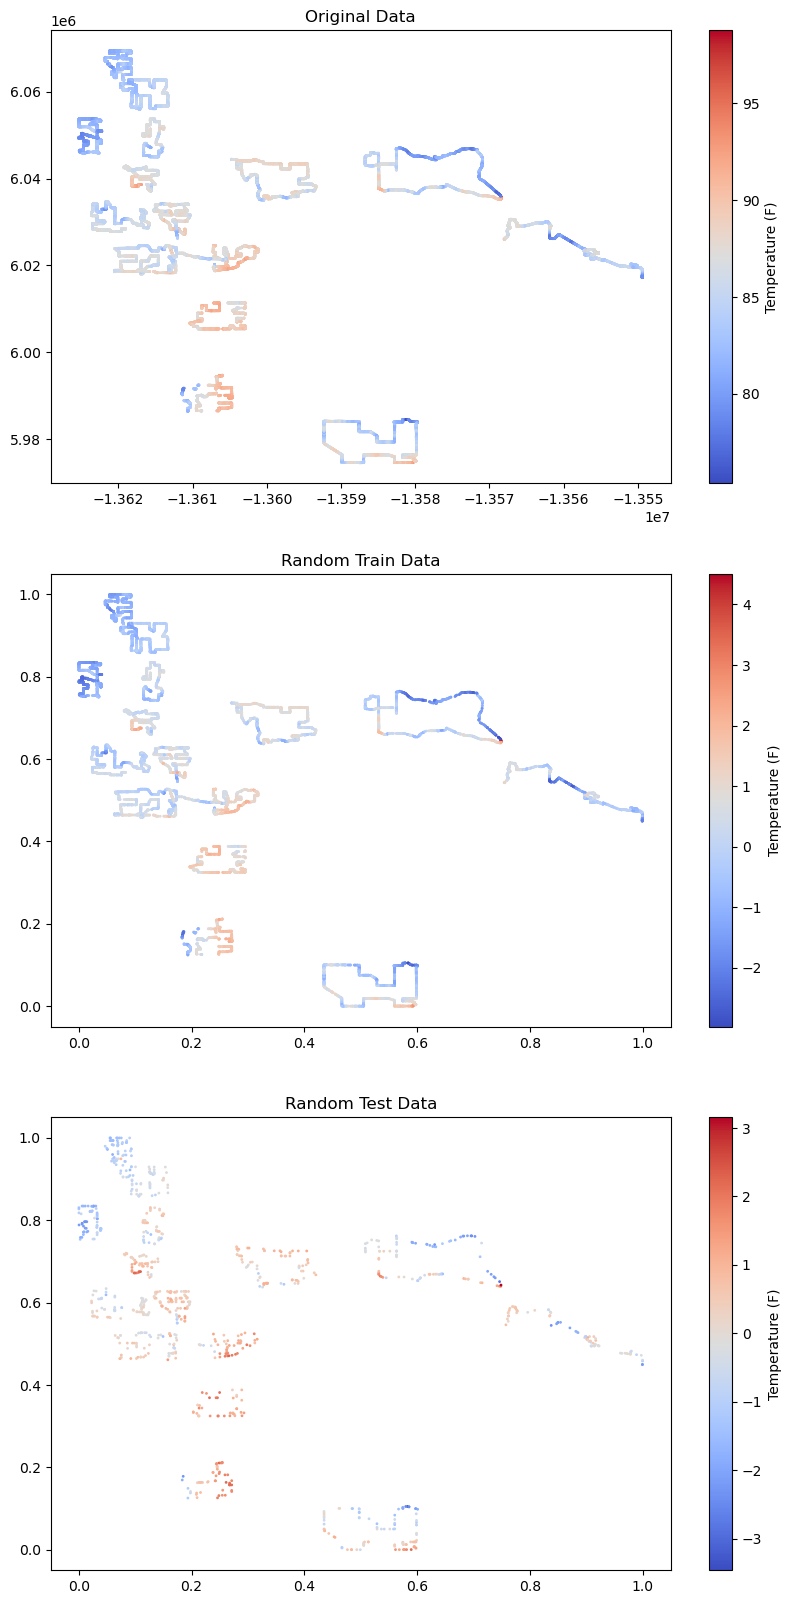

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(10,20))
scatter_orig = ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=1)
ax[0].set_title('Original Data')
fig.colorbar(scatter_orig, ax=ax[0], label='Temperature (F)')

scatter_rand = ax[1].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='coolwarm', s=1)
ax[1].set_title('Random Train Data')
fig.colorbar(scatter_rand, ax=ax[1], label='Temperature (F)')

scatter_test = ax[2].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='coolwarm', s=1)
ax[2].set_title('Random Test Data')
fig.colorbar(scatter_test, ax=ax[2], label='Temperature (F)')


### Model training

In [12]:
import torch
# Convert the arrays to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [13]:
from models import NonStationaryGPModel, ExactGPModel
import gpytorch

In [14]:
# Function to train the model
def train_model(train_x, train_y, likelihood, model_str, num_points=16):
    if model_str == 'ExactGP':
        model = ExactGPModel(train_x, train_y, likelihood)
    elif model_str == 'NonStationaryGP':
        model = NonStationaryGPModel(train_x, train_y, likelihood, num_points=num_points)

    print(f"Training {model_str}...")
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    best_params = None  # Store the best state_dict

    if model_str == 'NonStationaryGP':
        print(f"RBF Centers Before Training: \n{model.covar_module.rbf_centers.detach().numpy()}")

    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        optimizer.step()

        print(f"Iter {i+1}/30 - Loss: {loss.item():.3f}")
        print(f"Base Kernel Lengthscale: {model.covar_module.base_kernel.lengthscale.item()}")

        if model_str == 'NonStationaryGP':
            print(f"RBF Widths: \n{model.covar_module.raw_rbf_widths.detach().numpy()}")
            print(f"Signal Variance: \n{model.covar_module.coefficients.detach().numpy()}")

        if loss.item() < best_loss:
            print('Saving model parameters...')
            best_loss = loss.item()
            best_params = model.state_dict() # Ensure deep copy
    
    # Restore the best model parameters
    # if best_params is not None:
    #     print("Loading best model parameters...")
    #     print(f"Base Kernel Lengthscale: {model.covar_module.base_kernel.lengthscale.item()}")
    #     model.load_state_dict(best_params)

    return model  # Ensure best model is returned

In [15]:
# Define likelihood and GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Train the GP model using your Non-Stationary Kernel
exact_gp_model = train_model(x_train, y_train, likelihood, 'ExactGP')
# print('\n')
ns_gp_model = train_model(x_train, y_train, likelihood, 'NonStationaryGP', num_points=9)

Training ExactGP...
Iter 1/30 - Loss: 1.109
Base Kernel Lengthscale: 0.6443966627120972
Saving model parameters...
Iter 2/30 - Loss: 1.087
Base Kernel Lengthscale: 0.5980796217918396
Saving model parameters...
Iter 3/30 - Loss: 1.064
Base Kernel Lengthscale: 0.5541466474533081
Saving model parameters...
Iter 4/30 - Loss: 1.041
Base Kernel Lengthscale: 0.5125494599342346
Saving model parameters...
Iter 5/30 - Loss: 1.018
Base Kernel Lengthscale: 0.47323665022850037
Saving model parameters...
Iter 6/30 - Loss: 0.994
Base Kernel Lengthscale: 0.43615177273750305
Saving model parameters...
Iter 7/30 - Loss: 0.969
Base Kernel Lengthscale: 0.4012364149093628
Saving model parameters...
Iter 8/30 - Loss: 0.944
Base Kernel Lengthscale: 0.36843210458755493
Saving model parameters...
Iter 9/30 - Loss: 0.918
Base Kernel Lengthscale: 0.33768200874328613
Saving model parameters...
Iter 10/30 - Loss: 0.892
Base Kernel Lengthscale: 0.3089258372783661
Saving model parameters...
Iter 11/30 - Loss: 0.865


/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.0913573503494263 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 27/30 - Loss: 0.603
Base Kernel Lengthscale: 0.13513000309467316
RBF Widths: 
[ 2.5522766   0.18152314  2.3574364   2.530333    2.442229    2.8988407
 -0.1336593   2.4704356   1.9692585 ]
Signal Variance: 
[-1.9554689  -0.8407272  -3.3629699  -1.9928476  -2.1873767  -1.5012424
 -0.42542702 -2.423493   -1.2472926 ]
Iter 28/30 - Loss: 0.629
Base Kernel Lengthscale: 0.13025270402431488
RBF Widths: 
[ 2.5739458   0.18744682  2.3736112   2.5511646   2.460144    2.9324489
 -0.13937788  2.4891982   2.0115788 ]
Signal Variance: 
[-1.9749188 -0.8578425 -3.382097  -2.0116732 -2.2055044 -1.5200111
 -0.4401306 -2.4421654 -1.2655909]


/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.4628989696502686 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 29/30 - Loss: 0.656
Base Kernel Lengthscale: 0.12570367753505707
RBF Widths: 
[ 2.5941408   0.19398561  2.3888018   2.570621    2.4770389   2.9644523
 -0.14424656  2.5066478   2.0515888 ]
Signal Variance: 
[-1.9930923  -0.87373024 -3.3999064  -2.0292478  -2.222394   -1.5375035
 -0.45374018 -2.4595935  -1.2826959 ]


/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.738703966140747 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 30/30 - Loss: 0.694
Base Kernel Lengthscale: 0.12139767408370972
RBF Widths: 
[ 2.6132166   0.20121218  2.402847    2.5887039   2.4923067   2.9935968
 -0.14855096  2.522402    2.0880947 ]
Signal Variance: 
[-2.0098727 -0.8883427 -3.4164035 -2.0455298 -2.2380571 -1.5537518
 -0.4664431 -2.475828  -1.2986954]


### Model evaluation

In [16]:
# Function to generate predictions using the trained GP model
def generate_predictions(model, likelihood, test_x):
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        predictive_dist = likelihood(model(test_x))  # GP predictive distribution
        mean_pred = predictive_dist.mean.numpy()

        # Directly extract diagonal variance from covariance matrix
        std_pred = torch.sqrt(predictive_dist.covariance_matrix.diagonal()).numpy()

    return mean_pred, std_pred

Sampling points from the GP

How do we sample points from GP?
- 100m resolution -> 10 Hz (10 samples/km)

How many samples is enough to generate a relibale Fourier analysis?
Cool figure: generate 10 different samples

create a dataloader to send batches of samples at a time!

visualize the standard deviation that can be an additional point of analysis when looking at the dominant frequencies in each city

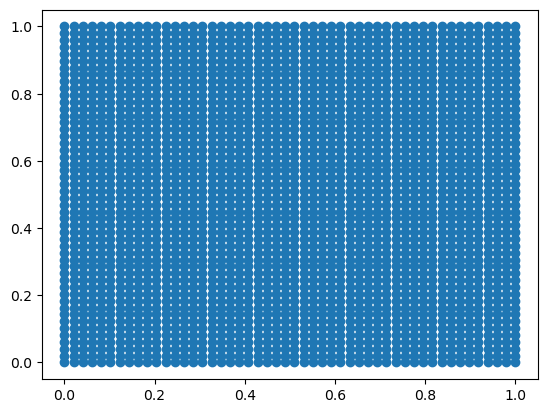

In [22]:
# Generate 2D grid
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])
plt.scatter(points[:, 0], points[:, 1])

In [23]:
# Generate a grid of test points
x_test = torch.tensor(x_test, dtype=torch.float32)
points = torch.tensor(points, dtype=torch.float32)

# Generate predictions for sampled points
# mean_pred_ex, std_pred_ex = generate_predictions(exact_gp_model, likelihood, points)
mean_pred_ns, std_pred_ns = generate_predictions(ns_gp_model, likelihood, points)

# y_pred_ex = mean_pred_ex * y_std + y_mean
y_pred_ns = mean_pred_ns * y_std + y_mean

/var/folders/vf/lbwx_pzs6sq_d5d_w0fcr2zm0000gn/T/ipykernel_35854/2469808476.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.43681561946868896 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Visualize sampled points from GP

### Detrend sample GP (before subjecting to Fourier transform)

python(38101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Text(0.5, 1.0, 'Detrended')

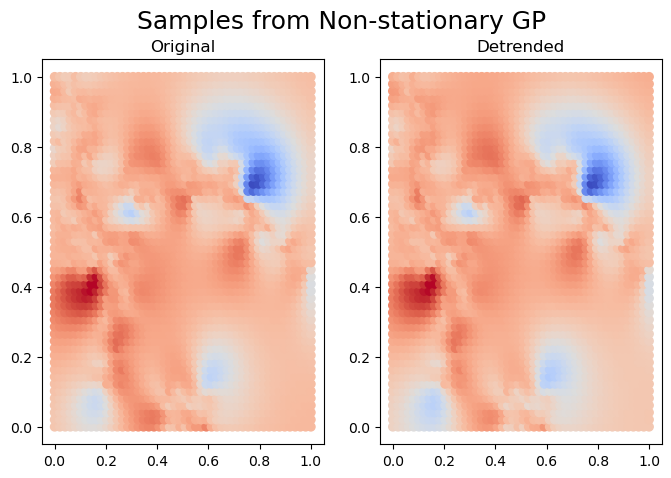

In [24]:
from scipy.signal import detrend

z_detrended = detrend(y_pred_ns, type='linear')

fig, ax = plt.subplots(1,2, figsize = (8,5))
fig.suptitle('Samples from Non-stationary GP', fontsize=18)
ax[0].scatter(points[:, 0], points[:, 1], c=y_pred_ns, cmap="coolwarm")
ax[0].set_title('Original')
ax[1].scatter(points[:, 0], points[:, 1], c=z_detrended, cmap="coolwarm")
ax[1].set_title('Detrended')


#### Visualized predictions on train and test data locations

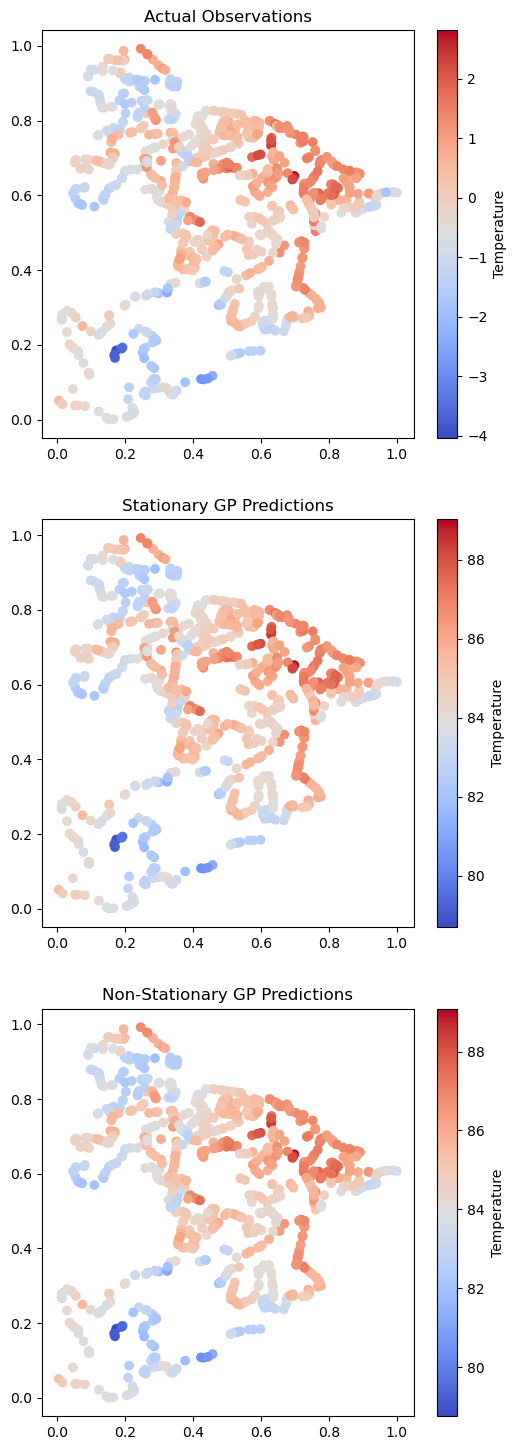

In [20]:
import matplotlib.pyplot as plt

# Create side-by-side contour plots
fig, ax = plt.subplots(3, 1, figsize=(6, 18))

# Contour plot for actual observations
contour0 = ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap="coolwarm")
fig.colorbar(contour0, ax=ax[0], label="Temperature")
ax[0].set_title("Actual Observations")

# Contour plot for Exact (Stationary) GP
contour1 = ax[1].scatter(x_test[: ,0], x_test[:, 1], c=y_pred, cmap="coolwarm")
fig.colorbar(contour1, ax=ax[1], label="Temperature")
ax[1].set_title("Stationary GP Predictions")

# Contour plot for Non-Stationary GP
contour2 = ax[2].scatter(x_test[:, 0], x_test[:, 1], c=y_pred_ns, cmap="coolwarm")
fig.colorbar(contour2, ax=ax[2], label="Temperature")
ax[2].set_title("Non-Stationary GP Predictions")

plt.show()


## GP model comparisons

Atlanta (9 fixed points)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y[test_indices], y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.35
Exact GP R^2: 0.9808
Non-Stationary GP RMSE: 0.45
Non-Stationary GP R^2: 0.9686


Atlanta (4 fixed points)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y[test_indices], y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.36
Exact GP R^2: 0.9805
Non-Stationary GP RMSE: 0.41
Non-Stationary GP R^2: 0.9747


Atlanta (1 fixed point)

In [126]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.47
Exact GP R^2: 0.9647
Non-Stationary GP RMSE: 0.49
Non-Stationary GP R^2: 0.9613


Boston (9 fixed points)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y[test_indices], y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.20
Exact GP R^2: 0.9829
Non-Stationary GP RMSE: 0.24
Non-Stationary GP R^2: 0.9747


## Alternative way of measuring non-stationarity
[1] M. M. Noack, H. Luo, and M. D. Risser, “A unifying perspective on non-stationary kernels for deeper Gaussian processes,” APL Machine Learning, vol. 2, no. 1, p. 010902, Feb. 2024, doi: 10.1063/5.0176963.

In [55]:
import torch
import numpy as np
import gpytorch
# Define ExactGPModel (required for Gaussian Process regression)
class StationaryGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(StationaryGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Function to estimate GP hyperparameters in local subdomains
def measure_nonstationarity(X, y, m=10, size=0.2, c=50):
    """
    X: Coordinates (Nx2 matrix of lat/lon)
    y: Temperature values (Nx1)
    m: Number of iterations
    size: Size of the subdomain (percentage)
    c: Number of selected points in each iteration
    """
    length_scales = []
    signal_variances = []
    final_loss = []
    noises = []

    fig, ax = plt.subplots(m,1, figsize = (18, 3))

    for i in range(m):
        # Select a random subdomain
        # a = np.random.uniform(0, 1 - size, X.shape[1])  # Start point
        a = np.random.uniform(0, 1 - size)
        b = a + size  # End point

        # Find points within the subdomain
        # mask = np.all((X >= a) & (X <= b), axis=1)
        mask = (X >= a) & (X <= b)
        subdomain_points = X[mask]
        subdomain_values = y[mask]


        if len(subdomain_points) < c:
            continue  # Skip if not enough points

        # Randomly sample c points from the subdomain
        # indices = np.random.uniform.choice(len(subdomain_points), c, replace=False)

        # Sample `c` random indices from a uniform distribution
        indices = np.random.uniform(0, len(subdomain_points), c).astype(int)

        # Ensure indices are within valid range
        # indices = np.clip(indices, 0, len(subdomain_points) - 1)
        X_t = torch.tensor(subdomain_points[indices], dtype=torch.float32)
        y_t = torch.tensor(subdomain_values[indices], dtype=torch.float32)
        ax[i].scatter(X_t, y_t)
        # print(X_t)
        # print(y_t)
        # plt.plot(X_t, y_t)

        # Fit a stationary GP
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = StationaryGPModel(X_t, y_t, likelihood)
        model.train()
        likelihood.train()

        # Optimize GP hyperparameters using MLE
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for _ in range(20):  # Small training loop
            optimizer.zero_grad()
            output = model(X_t)
            loss = -mll(output, y_t)
            loss.backward()
            optimizer.step()

        # Extract hyperparameters
        signal_variance = model.covar_module.outputscale.item()
        length_scale = model.covar_module.base_kernel.lengthscale.item()

        # Store results
        signal_variances.append(signal_variance)
        length_scales.append(length_scale)
        loss = -mll(output, y_t)
        final_loss.append(loss.item())
        noises.append(model.likelihood.noise.item())
    
    plt.tight_layout
    plt.show()

    return signal_variances, length_scales, final_loss, noises

In [27]:
# Example usage with synthetic data
np.random.seed(42)
num_points = 1000
X = np.random.rand(num_points, 2)  # Random latitude/longitude
y = np.sin(10 * X[:, 0]) + np.cos(10 * X[:, 1]) + 0.1 * np.random.randn(num_points)  # Synthetic temperature

In [30]:
X.shape, y.shape

((1000, 2), (1000,))

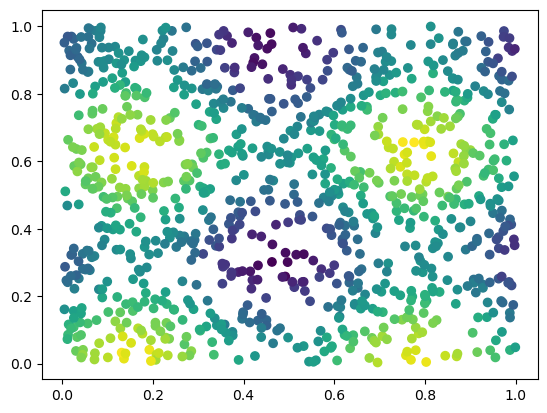

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = 'viridis')

In [44]:
signal_variances, length_scales = measure_nonstationarity(X, y, m=20, size=0.3, c=50)

# Print results
print(f"Signal Variances: {str(signal_variances)}")
print(f"Length Scales: {str(length_scales)}")
print(f"Mean Signal Variance: {np.mean(signal_variances):.3f}")
print(f"Mean Length Scale: {np.mean(length_scales):.3f}")
print(f"Signal Variance Spread: {np.std(signal_variances)}")
print(f"Length Scale Spread: {np.std(length_scales)}")

Signal Variances: [1.5350335836410522, 1.3764780759811401, 0.7179362773895264, 1.327297568321228, 1.625792145729065, 1.6714972257614136, 1.6693668365478516, 1.6207534074783325, 0.25020188093185425, 1.6944141387939453, 1.6549832820892334, 1.4861334562301636, 1.2567474842071533, 1.6673808097839355, 1.3307722806930542, 1.6641300916671753, 1.6532402038574219, 1.6764358282089233, 1.6870800256729126, 1.4321790933609009]
Length Scales: [0.23765793442726135, 0.2466670423746109, 0.14433343708515167, 0.23206186294555664, 0.22670765221118927, 0.2197967767715454, 0.21856962144374847, 0.23107708990573883, 0.3907795250415802, 0.22523453831672668, 0.21887873113155365, 0.2243974357843399, 0.26619952917099, 0.21705937385559082, 0.24708515405654907, 0.24016842246055603, 0.2497338503599167, 0.24051934480667114, 0.24717497825622559, 0.21177330613136292]
Mean Signal Variance: 1.450
Mean Length Scale: 0.237
Signal Variance Spread: 0.35757525946486735
Length Scale Spread: 0.042444888321756996


### Testing it on Boston Data

In [48]:
X, y = coordinates, gdf.T_F.to_numpy()

In [66]:
x_norm.shape, y_norm.shape

((20247, 2), (20247,))

In [84]:
signal_variances, length_scales = measure_nonstationarity(x_norm, y_norm, m=100, size=0.5, c=400)

In [82]:
# Print results
print(f"Signal Variances: {str(signal_variances)}")
print(f"Length Scales: {str(length_scales)}")
print(f"Mean Signal Variance: {np.mean(signal_variances):.3f}")
print(f"Mean Length Scale: {np.mean(length_scales):.3f}")
print(f"Signal Variance Spread: {np.std(signal_variances)}")
print(f"Length Scale Spread: {np.std(length_scales)}")

Signal Variances: [2.1775684356689453, 2.2069015502929688, 2.048252582550049, 2.2012429237365723, 2.1484756469726562, 2.1692111492156982, 2.1968343257904053, 1.9553534984588623, 2.211698532104492, 2.1517984867095947, 2.036198616027832, 2.1428921222686768, 2.205437183380127, 2.193537712097168, 2.1373231410980225, 2.1486270427703857, 2.206948757171631, 2.0498454570770264, 2.1659083366394043, 2.1731655597686768, 2.1971523761749268, 2.174543619155884, 2.132944107055664, 2.078007698059082, 2.1645667552948, 2.109733819961548, 2.183518409729004, 2.143648624420166, 2.1087021827697754, 2.137377977371216, 2.141129732131958, 2.2064666748046875, 2.188169479370117, 2.186809778213501, 2.147036075592041, 2.2109410762786865, 2.1799240112304688, 2.179713487625122, 2.0379865169525146, 2.2080628871917725, 2.1638801097869873, 2.108712911605835, 2.1871845722198486, 2.1827304363250732, 2.1625473499298096, 2.188783645629883, 2.183311700820923, 2.1703402996063232, 2.1420445442199707, 2.1790549755096436, 2.082

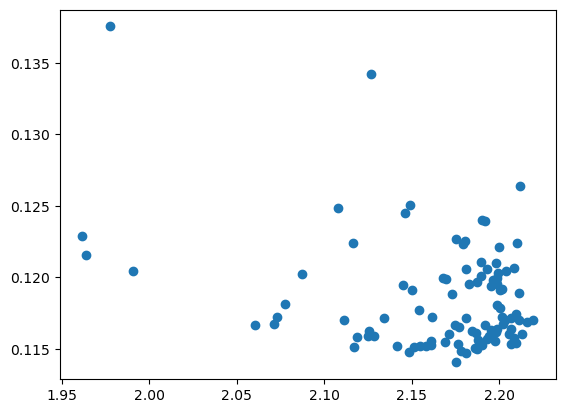

In [85]:
plt.scatter(signal_variances, length_scales)

### Testing it on synthetic data

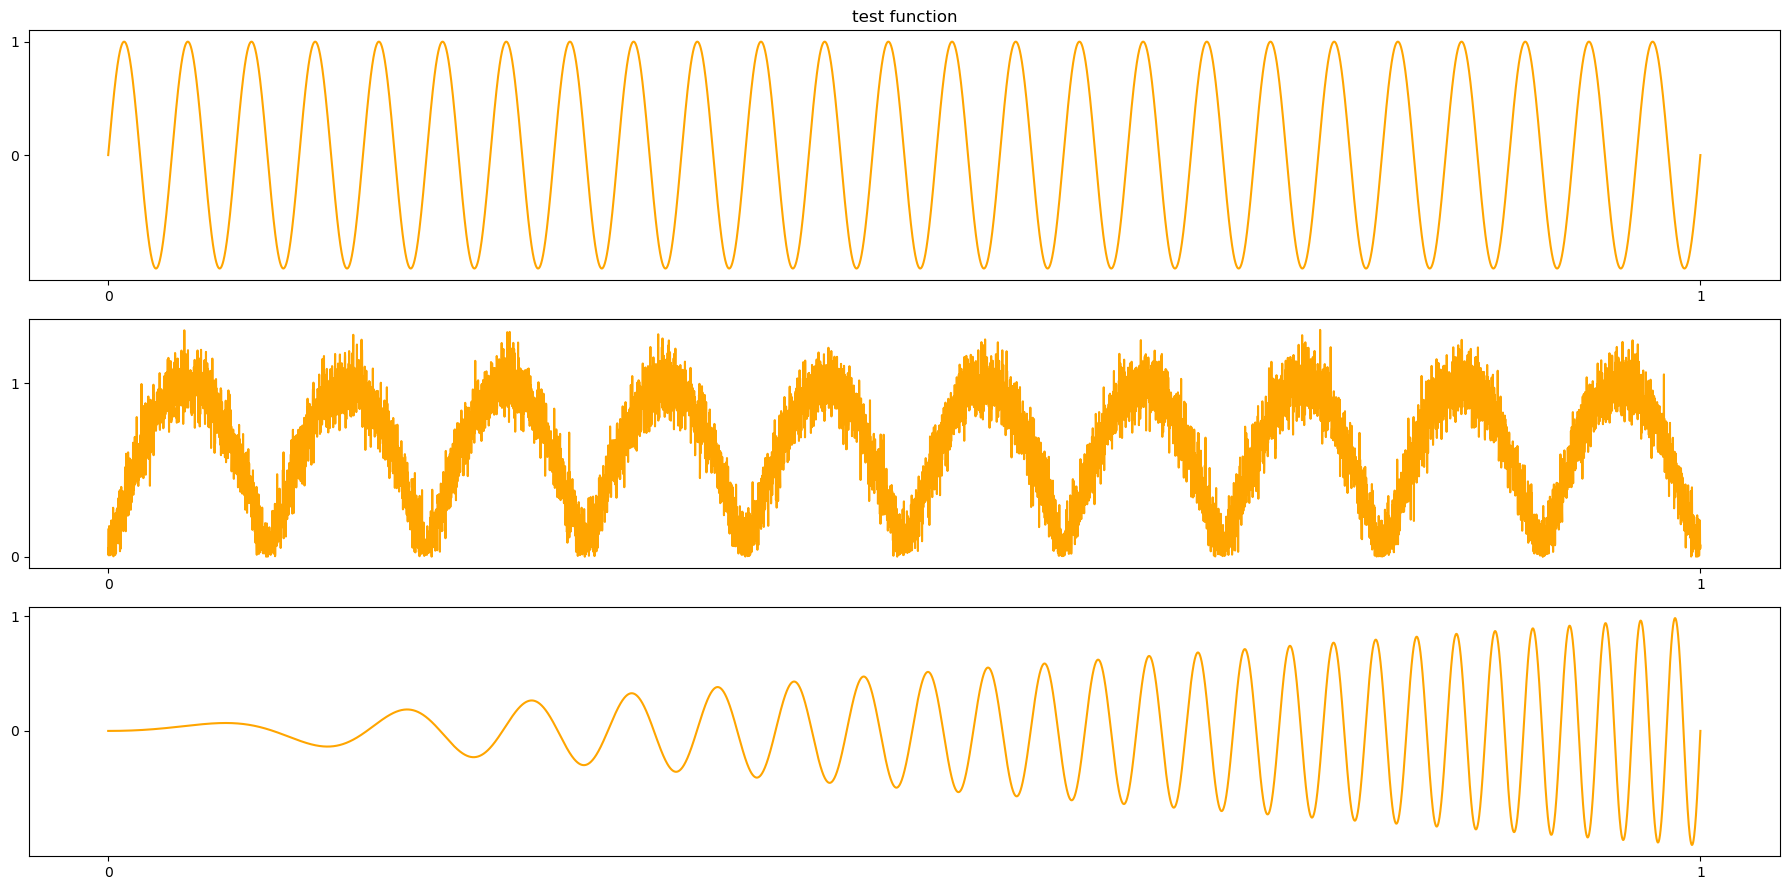

In [31]:
# Generate X values (uniformly spaced)
X = np.linspace(0, 1, 10000)

# Function 1: High-Frequency Sine Wave
y1 = np.sin(50 * np.pi * X)  # High-frequency oscillations

# Function 2: Randomized Sinusoidal Variation
np.random.seed(42)
y2 = np.abs(np.sin(10 * np.pi * X) + 0.1 * np.random.randn(len(X)))  # Random noise added

# Function 3: Increasing Frequency Sine Wave
y3 = X*np.sin((5 + 45 * X) * np.pi * X)  # Frequency increases with X

# Plot the functions
fig, axes = plt.subplots(3, 1, figsize=(18, 9))

axes[0].plot(X, y1, color='orange')
axes[0].set_title("test function")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])

axes[1].plot(X, y2, color='orange')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])

axes[2].plot(X, y3, color='orange')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])

plt.tight_layout()
plt.show()


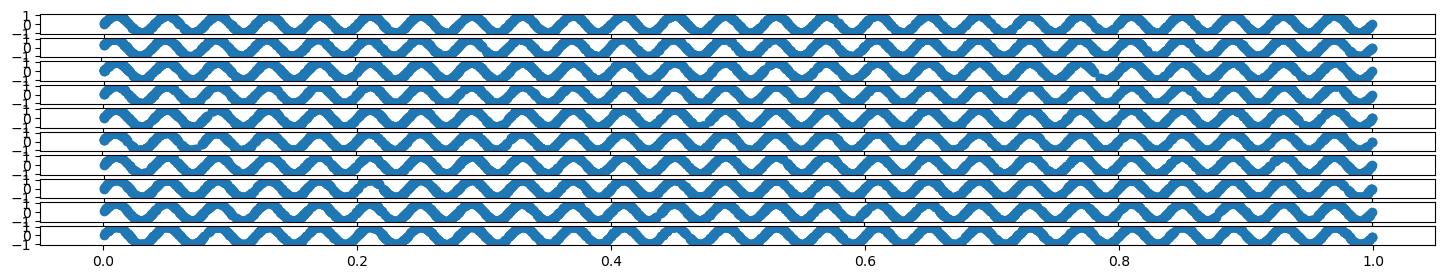

[0.13310083746910095, 0.127107635140419, 0.1253567934036255, 0.1297520399093628, 0.12657666206359863, 0.12364385277032852, 0.12656117975711823, 0.12795747816562653, 0.1334500014781952, 0.1314765065908432]
[1.8366849422454834, 2.021933078765869, 0.41293570399284363, 1.9234288930892944, 2.0683183670043945, 0.4512723386287689, 0.44352856278419495, 1.9791139364242554, 1.846627950668335, 1.889153242111206]
[1.073108196258545, 1.0836201906204224, 1.07779061794281, 1.0830867290496826, 1.0841366052627563, 1.085180640220642, 1.0777355432510376, 1.0768030881881714, 1.066002607345581, 1.0768349170684814]
[0.5387679934501648, 0.5481947064399719, 0.5416252017021179, 0.5475457310676575, 0.5484298467636108, 0.5480217933654785, 0.5416538119316101, 0.5423159003257751, 0.5316483974456787, 0.5422419309616089]


In [57]:
signal_variances, length_scales, losses, noises = measure_nonstationarity(X, y1, m=10, size=1, c=2000)
print(signal_variances)
print(length_scales)
print(losses)
print(noises)

In [188]:
# Print results
print(f"Signal Variances: {str(signal_variances)}")
print(f"Length Scales: {str(length_scales)}")
print(f"Mean Signal Variance: {np.mean(signal_variances):.3f}")
print(f"Mean Length Scale: {np.mean(length_scales):.3f}")
print(f"Signal Variance Spread: {np.std(signal_variances)}")
print(f"Length Scale Spread: {np.std(length_scales)}")

Signal Variances: [0.012337427586317062, 0.01203752588480711, 0.013463904149830341, 0.01811106503009796, 0.014712126925587654, 0.010844042524695396, 0.03671141713857651, 0.010478922165930271, 0.008174744434654713, 0.05806572735309601, 0.012373765930533409, 0.01156712882220745, 0.0319109782576561, 0.010804364457726479, 0.024552877992391586, 0.010748491622507572, 0.010105349123477936, 0.012361808679997921, 0.05041833594441414, 0.03123139776289463, 0.014349742792546749, 0.014037473127245903, 0.0119924396276474, 0.024201884865760803, 0.015393434092402458, 0.012403889559209347, 0.00904550589621067, 0.011953729204833508, 0.009779841639101505, 0.012289202772080898, 0.01568571850657463, 0.011794432997703552, 0.015393105335533619, 0.010253640823066235, 0.01902669668197632, 0.01194808166474104, 0.011938808485865593, 0.011034958995878696, 0.013251381926238537, 0.015552560798823833, 0.012666154652833939, 0.012472865171730518, 0.01192287728190422, 0.013566347770392895, 0.013371833600103855, 0.00669

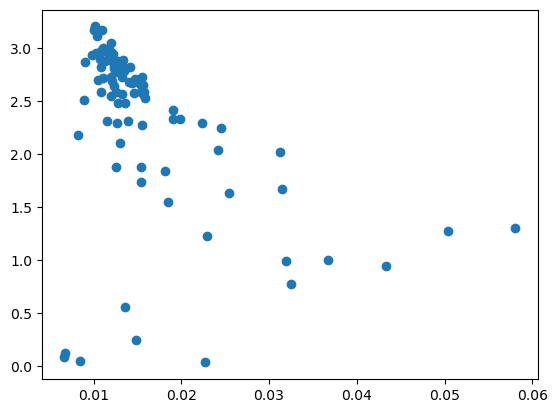

In [189]:
plt.scatter(signal_variances, length_scales)

In [202]:
# Fit a stationary GP
X = torch.tensor(X)
y1 = torch.tensor(y1)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y1, likelihood)
model.train()
likelihood.train()

# Optimize GP hyperparameters using MLE
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for _ in range(50):  # Small training loop
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y1)
    loss.backward()
    optimizer.step()

# Extract hyperparameters
signal_variance = model.covar_module.outputscale.item()
length_scale = model.covar_module.base_kernel.lengthscale.item()

print(signal_variance)
print(length_scale)

/var/folders/vf/lbwx_pzs6sq_d5d_w0fcr2zm0000gn/T/ipykernel_9816/2770654842.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/var/folders/vf/lbwx_pzs6sq_d5d_w0fcr2zm0000gn/T/ipykernel_9816/2770654842.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1 = torch.tensor(y1)


0.013034552335739136
2.815667152404785


## Using Fourier transforms to extrapolate length scales from the GP

### Synthetic data (longer length scale)

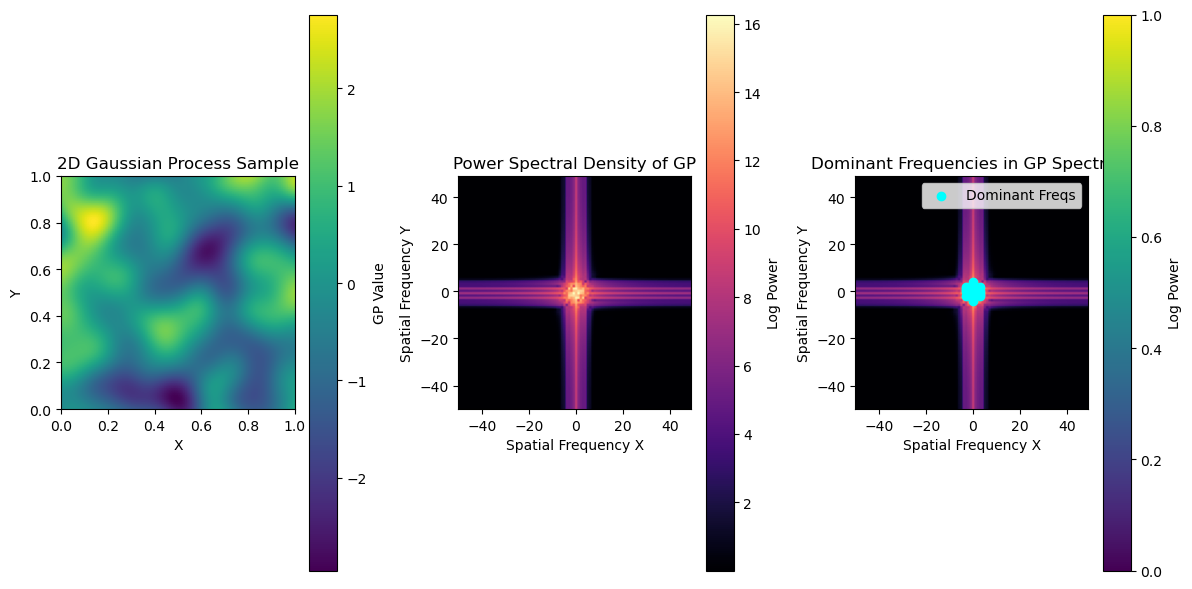

(np.float64(-1.0),
 np.float64(0.0),
 [(np.float64(0.0), np.float64(-4.0)),
  (np.float64(0.0), np.float64(-3.0)),
  (np.float64(-3.0), np.float64(-2.0)),
  (np.float64(-1.0), np.float64(-2.0)),
  (np.float64(0.0), np.float64(-2.0)),
  (np.float64(1.0), np.float64(-2.0)),
  (np.float64(3.0), np.float64(-2.0)),
  (np.float64(-1.0), np.float64(-1.0)),
  (np.float64(0.0), np.float64(-1.0)),
  (np.float64(1.0), np.float64(-1.0)),
  (np.float64(2.0), np.float64(-1.0)),
  (np.float64(3.0), np.float64(-1.0)),
  (np.float64(-3.0), np.float64(0.0)),
  (np.float64(-2.0), np.float64(0.0)),
  (np.float64(-1.0), np.float64(0.0)),
  (np.float64(0.0), np.float64(0.0)),
  (np.float64(1.0), np.float64(0.0)),
  (np.float64(2.0), np.float64(0.0)),
  (np.float64(3.0), np.float64(0.0)),
  (np.float64(-3.0), np.float64(1.0)),
  (np.float64(-2.0), np.float64(1.0)),
  (np.float64(-1.0), np.float64(1.0)),
  (np.float64(0.0), np.float64(1.0)),
  (np.float64(1.0), np.float64(1.0)),
  (np.float64(-3.0), np.float6

In [58]:
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# Define GP parameters
Nx, Ny = 50, 50  # Grid size
length_scale = 0.01  # GP length scale
sigma_f = 1.0  # GP signal variance

# Generate 2D grid
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

# Compute RBF kernel matrix
distances = cdist(points, points, metric='euclidean')
kernel = np.exp(-distances**2 / (2 * length_scale**2))
kernel = kernel.reshape(Nx * Ny, Nx * Ny)

# Sample from multivariate normal with RBF covariance
gp_sample = multivariate_normal.rvs(mean=np.zeros(Nx * Ny), cov=kernel).reshape(Nx, Ny)

# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes
fx = np.fft.fftshift(np.fft.fftfreq(Nx))
fy = np.fft.fftshift(np.fft.fftfreq(Ny))

# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes (correct spacing!)
N = gp_sample.shape[0]  # assume square grid
dx = 1 / (N - 1)
fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# Find peak frequency in the PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]  # column → x
dominant_freq_y = fy[peak_idx[0]]  # row → y

# Flatten PSD and compute threshold for top 5%
flattened_psd = psd_gp.flatten()
threshold = np.percentile(flattened_psd, 95)

# Get indices of PSD values above the threshold
indices = np.argwhere(psd_gp >= threshold)

# Get corresponding frequencies
dominant_frequencies = []
for i, j in indices:
    freq_x = fx[j]  # j = column = fx
    freq_y = fy[i]  # i = row = fy
    dominant_frequencies.append((freq_x, freq_y))

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.suptitle(f'{city}', fontsize=28)

# GP Sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample, cmap="coolwarm", extent=[0, 1, 0, 1])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel("Spatial Frequency X (cycles/unit)")
plt.ylabel("Spatial Frequency Y (cycles/unit)")
plt.colorbar(label="Log Power")

# Dominant Frequencies Overlay
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter(
    [f[0] for f in dominant_frequencies],
    [f[1] for f in dominant_frequencies],
    color='cyan', s=15, label="Dominant Freqs"
)
plt.title("Top 5% Dominant Frequencies")
plt.xlabel("Spatial Frequency X (cycles/unit)")
plt.ylabel("Spatial Frequency Y (cycles/unit)")
plt.legend()

plt.tight_layout()
plt.show()

# Display results
print(f"Peak frequency: fx = {dominant_freq_x:.3f}, fy = {dominant_freq_y:.3f}")
print("Sample of top dominant frequencies (fx, fy):")
print(dominant_frequencies[:10])  # show just a few

### Synthetic data (shorter length scale)

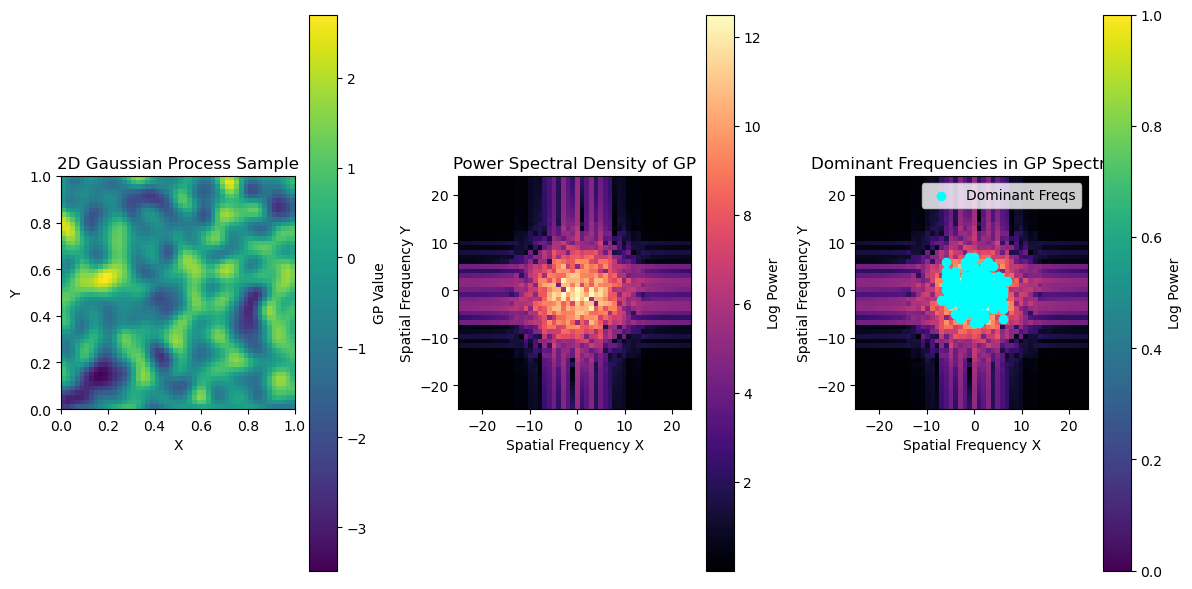

(np.float64(0.0),
 np.float64(1.0),
 [(np.float64(0.0), np.float64(-7.000000000000001)),
  (np.float64(1.0), np.float64(-7.000000000000001)),
  (np.float64(-3.0), np.float64(-6.0)),
  (np.float64(2.0), np.float64(-6.0)),
  (np.float64(6.0), np.float64(-6.0)),
  (np.float64(-4.0), np.float64(-5.0)),
  (np.float64(-3.0), np.float64(-5.0)),
  (np.float64(-2.0), np.float64(-5.0)),
  (np.float64(0.0), np.float64(-5.0)),
  (np.float64(1.0), np.float64(-5.0)),
  (np.float64(2.0), np.float64(-5.0)),
  (np.float64(-2.0), np.float64(-4.0)),
  (np.float64(-1.0), np.float64(-4.0)),
  (np.float64(0.0), np.float64(-4.0)),
  (np.float64(4.0), np.float64(-4.0)),
  (np.float64(6.0), np.float64(-4.0)),
  (np.float64(-5.0), np.float64(-3.0)),
  (np.float64(-3.0), np.float64(-3.0)),
  (np.float64(-2.0), np.float64(-3.0)),
  (np.float64(-1.0), np.float64(-3.0)),
  (np.float64(0.0), np.float64(-3.0)),
  (np.float64(1.0), np.float64(-3.0)),
  (np.float64(2.0), np.float64(-3.0)),
  (np.float64(4.0), np.float6

In [3]:
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

# Define GP parameters
Nx, Ny = 50, 50  # Grid size
length_scale = 0.05  # GP length scale
sigma_f = 1.0  # GP signal variance

# Generate 2D grid
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

# Compute RBF kernel matrix
distances = cdist(points, points, metric='euclidean')
kernel = np.exp(-distances**2 / (2 * length_scale**2))
kernel = kernel.reshape(Nx * Ny, Nx * Ny)

# Sample from multivariate normal with RBF covariance
gp_sample = multivariate_normal.rvs(mean=np.zeros(Nx * Ny), cov=kernel).reshape(Nx, Ny)

# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes
fx = np.fft.fftshift(np.fft.fftfreq(Nx)) * Nx
fy = np.fft.fftshift(np.fft.fftfreq(Ny)) * Ny

# Find peak frequencies in the 2D PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]
dominant_freq_y = fy[peak_idx[0]]

# Find multiple peaks using a threshold (e.g., top 5%)
threshold = 0.05 * np.max(psd_gp)
peak_indices = np.argwhere(psd_gp > threshold)
dominant_frequencies = [(fx[j], fy[i]) for i, j in peak_indices]

# Plot results
plt.figure(figsize=(12, 6))

# Plot the GP sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample, cmap="viridis", extent=[0, 1, 0, 1])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# Plot the PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel("Spatial Frequency X")
plt.ylabel("Spatial Frequency Y")
plt.colorbar(label="Log Power")

# Mark dominant frequencies
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter([f[0] for f in dominant_frequencies], [f[1] for f in dominant_frequencies], color='cyan', label="Dominant Freqs")
plt.title("Dominant Frequencies in GP Spectrum")
plt.xlabel("Spatial Frequency X")
plt.ylabel("Spatial Frequency Y")
plt.legend()
plt.colorbar(label="Log Power")

plt.tight_layout()
plt.show()

# Display dominant frequency results
dominant_freq_x, dominant_freq_y, dominant_frequencies


### GP trained on city data

In [29]:
# Standardize the labels
mean = z_detrended.mean()
std = z_detrended.std()

y_pred_ns_norm = (z_detrended - mean) / (std)
y_pred_ns_norm

array([-0.58088136, -0.6971446 , -0.83230889, ...,  0.40537255,
        0.44793439,  0.4864412 ])

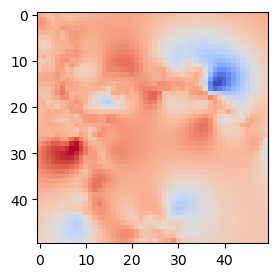

In [30]:
gp_sample = np.flipud(y_pred_ns_norm.reshape((50,50)))
plt.figure(figsize=(3,3))
plt.imshow(gp_sample, cmap='coolwarm')

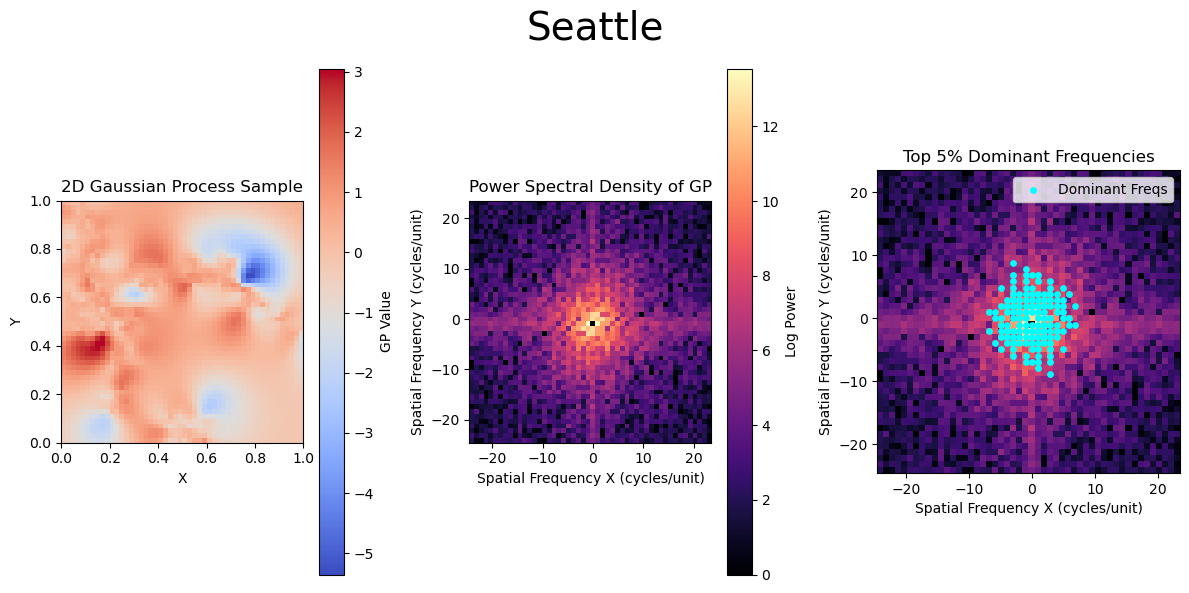

Peak frequency: fx = -0.980, fy = 0.000
Sample of top dominant frequencies (fx, fy):
[(np.float64(2.94), np.float64(-8.82)), (np.float64(0.98), np.float64(-7.84)), (np.float64(-0.98), np.float64(-6.859999999999999)), (np.float64(0.0), np.float64(-6.859999999999999)), (np.float64(0.98), np.float64(-6.859999999999999)), (np.float64(2.94), np.float64(-6.859999999999999)), (np.float64(-2.94), np.float64(-5.88)), (np.float64(-0.98), np.float64(-5.88)), (np.float64(0.98), np.float64(-5.88)), (np.float64(2.94), np.float64(-5.88))]


In [96]:
# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes (correct spacing!)
N = gp_sample.shape[0]  # assume square grid
dx = 1 / (N - 1)
fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# Find peak frequency in the PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]  # column → x
dominant_freq_y = fy[peak_idx[0]]  # row → y

# Flatten PSD and compute threshold for top 5%
flattened_psd = psd_gp.flatten()
threshold = np.percentile(flattened_psd, 95)

# Get indices of PSD values above the threshold
indices = np.argwhere(psd_gp >= threshold)

# Get corresponding frequencies
dominant_frequencies = []
for i, j in indices:
    freq_x = fx[j]  # j = column = fx
    freq_y = fy[i]  # i = row = fy
    dominant_frequencies.append((freq_x, freq_y))

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.suptitle(f'{city}', fontsize=28)

# GP Sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample, cmap="coolwarm", extent=[0, 1, 0, 1])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel("Spatial Frequency X (cycles/unit)")
plt.ylabel("Spatial Frequency Y (cycles/unit)")
plt.colorbar(label="Log Power")

# Dominant Frequencies Overlay
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter(
    [f[0] for f in dominant_frequencies],
    [f[1] for f in dominant_frequencies],
    color='cyan', s=15, label="Dominant Freqs"
)
plt.title("Top 5% Dominant Frequencies")
plt.xlabel("Spatial Frequency X (cycles/unit)")
plt.ylabel("Spatial Frequency Y (cycles/unit)")
plt.legend()

plt.tight_layout()
plt.show()

# Display results
print(f"Peak frequency: fx = {dominant_freq_x:.3f}, fy = {dominant_freq_y:.3f}")
print("Sample of top dominant frequencies (fx, fy):")
print(dominant_frequencies[:10])  # show just a few

In [97]:
list_freq = []
for item in dominant_frequencies:
    list_freq.append(item[0])
    list_freq.append(item[1])
list_freq

[np.float64(2.94),
 np.float64(-8.82),
 np.float64(0.98),
 np.float64(-7.84),
 np.float64(-0.98),
 np.float64(-6.859999999999999),
 np.float64(0.0),
 np.float64(-6.859999999999999),
 np.float64(0.98),
 np.float64(-6.859999999999999),
 np.float64(2.94),
 np.float64(-6.859999999999999),
 np.float64(-2.94),
 np.float64(-5.88),
 np.float64(-0.98),
 np.float64(-5.88),
 np.float64(0.98),
 np.float64(-5.88),
 np.float64(2.94),
 np.float64(-5.88),
 np.float64(-4.9),
 np.float64(-4.9),
 np.float64(-2.94),
 np.float64(-4.9),
 np.float64(0.0),
 np.float64(-4.9),
 np.float64(0.98),
 np.float64(-4.9),
 np.float64(2.94),
 np.float64(-4.9),
 np.float64(4.9),
 np.float64(-4.9),
 np.float64(-5.88),
 np.float64(-3.92),
 np.float64(-3.92),
 np.float64(-3.92),
 np.float64(-2.94),
 np.float64(-3.92),
 np.float64(-1.96),
 np.float64(-3.92),
 np.float64(-0.98),
 np.float64(-3.92),
 np.float64(0.0),
 np.float64(-3.92),
 np.float64(0.98),
 np.float64(-3.92),
 np.float64(1.96),
 np.float64(-3.92),
 np.float64(2

(array([ 2., 13., 29., 45., 26., 48., 45., 29., 13.,  2.]),
 array([-8.82 , -7.056, -5.292, -3.528, -1.764,  0.   ,  1.764,  3.528,
         5.292,  7.056,  8.82 ]),
 <BarContainer object of 10 artists>)

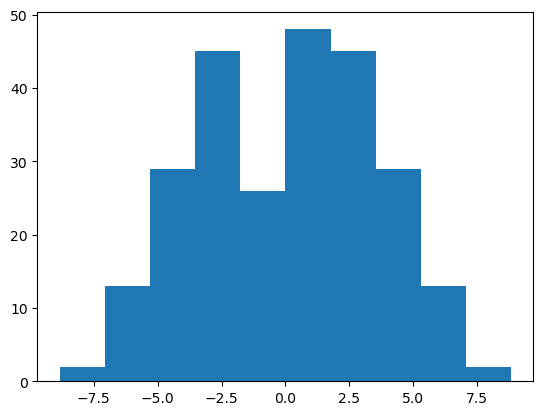

In [98]:
plt.hist(list_freq, bins=10)

Incorporate `x_scale` to get the physical distance of such patterns.

$\begin{equation}
    \lambda = \frac{1}{f} * (x_{max}-x_{min})
\end{equation}
    $

In [99]:
x_lengthscales = []
y_lengthscales = []
for (x,y) in dominant_frequencies:
    if x != 0.0 and y!= 0.0: # filter out the zeroes
        lsx = 1/x*x_scale[0]
        x_lengthscales.append(lsx)
        lsy = 1/y*x_scale[1]
        y_lengthscales.append(lsy)

Text(0, 0.5, 'Counts')

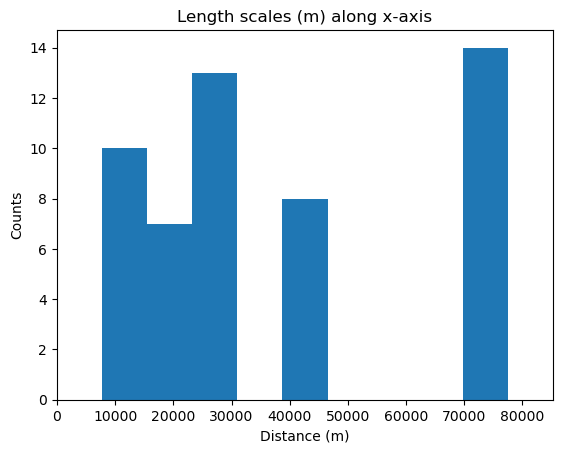

In [102]:
plt.hist(x_lengthscales, bins=20)
plt.xlim(left=0) # only show the positive values
plt.title('Length scales (m) along x-axis')
plt.xlabel('Distance (m)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

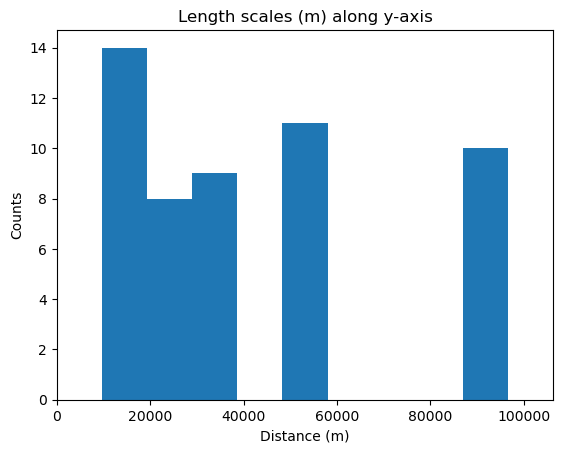

In [103]:
plt.hist(y_lengthscales, bins=20)
plt.xlim(left=0)
plt.title('Length scales (m) along y-axis')
plt.xlabel('Distance (m)')
plt.ylabel('Counts')

1. change the set of grid points
    divide by a thousand (m->km)
2. remove all normalizations!
    don't standardize z_detrended, still remove the trend
3. change it to celsius!
4. GPUs
5. to prevent overfitting, just do cross-validation 
6. in generating samples from the GP, use pred.samples() instead of using the mean (or maybe include the mean + 4 different sets of samples)

SCALE!

In [104]:
x_scale

array([75967.2035046 , 94699.42569275])